In [1]:
%%capture

%cd ..
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from unidecode import unidecode
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

pd.set_option('expand_frame_repr', True)
pd.set_option('display.column_space', 6)
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.show_dimensions', True)

# Limpeza dos Dados

In [3]:
REPORTS_PATH = Path("reports/figures")

## Carregamento dos dados

Inicialmente a gente precisa fazer o carregamento dos dados transformados do passo anterior.

In [4]:
DATA_PATH = Path('data/interim/') 
data_df = pd.read_csv(DATA_PATH / 'fake_true_news.csv')

Além disso, é importante ter uma visão geral do arquivo, pricipalmente os tipos dos dados, a quantidade de colunas e linhas carregadas. Além disso, é sempre bom verificar as linhas iniciais e finais para busca de algum possível erro de carregamento. 

In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   class                                    7200 non-null   object 
 1   text                                     7200 non-null   object 
 2   author                                   3625 non-null   object 
 3   link                                     7200 non-null   object 
 4   category                                 7200 non-null   object 
 5   date_of_publication                      7200 non-null   object 
 6   tokens                                   7200 non-null   float64
 7   words_no_punctuation                     7200 non-null   float64
 8   types                                    7200 non-null   float64
 9   links_inside                             5807 non-null   float64
 10  upper_words                              7200 no

In [6]:
data_df.head(2)

,class,text,author,link,category,date_of_publication,tokens,words_no_punctuation,types,links_inside,upper_words,verbs,subjuntive_imperative_verbs,nouns,adjectives,adverbs,modal_verbs,singular_first_second_personal_pronouns,plural_first_personal_pronouns,pronouns,pausality,characters,average_sentence_length,average_word_lenght,percentage_spelling_errors,emotiveness,diversity
0,True,﻿O Podemos decid...,Naira Trindade,http://politica....,politica,13/12/2017,168.0,148.0,107.0,NaN,0.0,24.0,2.0,43.0,5.0,4.0,3.0,0.0,0.0,7.0,3.33333,761.0,24.6667,5.14189,0.0,0.134328,0.72297
1,True,Em evento realiz...,Estadão Conteúdo,http://esportes....,sociedade_cotidiano,26/12/2017,349.0,294.0,182.0,NaN,3.0,60.0,1.0,72.0,19.0,24.0,4.0,0.0,0.0,29.0,2.75000,1477.0,14.7000,5.02381,0.0,0.325758,0.61904


In [7]:
data_df.tail(2)

,class,text,author,link,category,date_of_publication,tokens,words_no_punctuation,types,links_inside,upper_words,verbs,subjuntive_imperative_verbs,nouns,adjectives,adverbs,modal_verbs,singular_first_second_personal_pronouns,plural_first_personal_pronouns,pronouns,pausality,characters,average_sentence_length,average_word_lenght,percentage_spelling_errors,emotiveness,diversity
7198,Fake,"Há 400 anos, No...",NaN,https://www.diar...,tv_celebridades,03/09/0201,205.0,174.0,116.0,0.0,1.0,30.0,2.0,46.0,16.0,4.0,5.0,0.0,0.0,15.0,3.10000,834.0,17.4000,4.7931,0.0,0.263158,0.66666
7199,Fake,Forças Armadas a...,NaN,https://www.diar...,politica,02/05/2015,320.0,264.0,158.0,0.0,12.0,23.0,0.0,74.0,7.0,3.0,1.0,0.0,0.0,11.0,4.30769,1254.0,20.3077,4.7500,0.0,0.103093,0.59848


Como dá pra ver, aparentemente não existe nenhum problema no carregamento desses dados, então podemos partir para a próxima fase.

## Visão Geral dos Dados

Aqui vamos dar uma olhada geral nos dados. Esse passo é importante para tentar verificar erros mais comuns que podem ser verificados rapidamente, além de nos dar uma visão melhor do dataset. Para isso vamos usar uma versão alternativa à função describe do pandas.

In [8]:
data_df.describe(include="all").transpose() 

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
class,7200,2,True,3600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text,7200,7199,Suplicy particip...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author,3625,1436,Por G1,330,NaN,NaN,NaN,NaN,NaN,NaN,NaN
link,7200,7183,https://g1.globo...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,7200,6,politica,4180,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_of_publication,7200,3689,4/1/2018,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tokens,7200,NaN,NaN,NaN,742.763,774.155,11,183,416,1064.25,8634
words_no_punctuation,7200,NaN,NaN,NaN,646.172,674.902,9,157,362,928.25,7588
types,7200,NaN,NaN,NaN,306.896,260.201,9,106,208,440,2805
links_inside,5807,NaN,NaN,NaN,0.215085,0.604319,0,0,0,0,11


Vendo a tabela acima, algumas informações importantes podem ser vistas:

* Aparentemente existe um texto duplicado, já que idealmente deveríamos ter somente valores únicos nesse campo
* Temos alguns links duplicados também que talvez indiquem valores duplicados, já que se espera que cada notícia tenha um link único. (Isso não precisa ocorrer necessariamente, mas é interessante investigar)
* Muitos valores zero em "links_inside", "singular_first_second_personal_pronouns", "plural_first_personal_pronouns"
* Alguns missing values nas variáveis "author" e "links_inside"

## Pré-Processamento

Para facilitar o processo de análise das informações textuais (coluna "text") nessa fase de limpeza e nas próximas fases é importante fazer um tratamento desses textos. Como o dataset já contém informações sobre contagem de valores em maíusculo, contagem de textos com pontuação, podemos fazer um tratamento mais robusto, deixando apenas texto. Aqui faremos um tratamento básico de correção de case, remoção de caracteres especiais além de remoção de espaços desnecessários.

In [9]:
def text_base_cleaning(series):
    series = series.str.lower()
    series = series.str.strip()
    series = series.str.replace(r"\\t|\\n|\\r", "", regex=True)
    series = series.str.replace(r"\t|\n|\r", "", regex=True)
    series = series.str.replace('[^\w\s]', '', regex=True) # Removing Punctuation
    series = series.str.replace("  ", " ") # Removing Extra spaces
    series = series.apply(lambda x: unidecode(x) if isinstance(x, str) else np.nan)
    
    return series

In [10]:
text_before_cleaning = data_df.text.copy()

data_df.text = text_base_cleaning(data_df.text)
data_df.author = text_base_cleaning(data_df.author)

In [11]:
text_before_cleaning.iloc[2]

'\ufeffApós o prefeito de Manaus Arthur Virgílio (PSDB) ter enviado uma carta cobrando prévias no partido para definir o candidato à Presidência da República, o governador de São Paulo e presidente do partido Geraldo Alckmin negou um "racha" na legenda. Alckmin disse nesta terça-feira, 26, que "prévia não divide, prévia escolhe". Os dois postulam ao cargo de candidato a presidente em 2018.\n\n"Prévia não divide, prévia escolhe. Você pode escolher em um ambiente mais restrito e você pode escolher em um universo maior. Quanto mais você amplia e escuta, menos você erra, mais você acerta", disse. "As democracias, os partidos, não podem ser cartório. Eles precisam dar exemplo de vida democrática."\n\nQuestionado sobre possível desunião entre tucanos, Alckmin minimizou. "Olha, eu me lembro de uma matéria da imprensa sobre a prévia na capital. Chama tucanocídio político. O resultado do tucanocídio foi vitória no primeiro turno", afirmou o governador, em referência à vitória de João Doria (PSD

Agora temos as informações dispostas na seguinte forma

In [12]:
data_df.iloc[2].text

'apos o prefeito de manaus arthur virgilio psdb ter enviado uma carta cobrando previas no partido para definir o candidato a presidencia da republica o governador de sao paulo e presidente do partido geraldo alckmin negou um racha na legenda alckmin disse nesta tercafeira 26 que previa nao divide previa escolhe os dois postulam ao cargo de candidato a presidente em 2018previa nao divide previa escolhe voce pode escolher em um ambiente mais restrito e voce pode escolher em um universo maior quanto mais voce amplia e escuta menos voce erra mais voce acerta disse as democracias os partidos nao podem ser cartorio eles precisam dar exemplo de vida democraticaquestionado sobre possivel desuniao entre tucanos alckmin minimizou olha eu me lembro de uma materia da imprensa sobre a previa na capital chama tucanocidio politico o resultado do tucanocidio foi vitoria no primeiro turno afirmou o governador em referencia a vitoria de joao doria psdb a prefeitura de sao paulo no ano passado no dia 11 

In [13]:
data_df.head(1).text.values

array(['o podemos decidiu expulsar o deputado federal carlos gaguim do partido apos a policia federal fazer buscas a apreensoes no gabinete dele na camara com isso a legenda abre espaco para receber a senadora expulsa pelo pmdb katia abreu por meio de nota a legenda informou que o afastamento do parlamentar ja era algo acordado entre os filiados da sigla ainda que o parlamentar tenha comunicado a conclusao de sua desfiliacao para esta semana diante dos fatos noticiados hoje a executiva nacional do podemos solicita o imediato cancelamento de sua filiacao dos quadros do partidoo partido que no passado chegou a cogitar lancar o parlamentar como candidato ao senado diz que apoia a investigacao com a ampla apuracao dos eventuais crimes cometidos e a consequente responsabilizacao dos envolvidos para que todos sejam punidos com o maximo rigor da lei independentemente de posicao ou cargo ocupado'],
      dtype=object)

## Valores Duplicados

Inicialmente vamos buscar a existência de valores duplicados em todas as tabelas

In [14]:
data_df[data_df.duplicated(keep=False)]

,class,text,author,link,category,date_of_publication,tokens,words_no_punctuation,types,links_inside,upper_words,verbs,subjuntive_imperative_verbs,nouns,adjectives,adverbs,modal_verbs,singular_first_second_personal_pronouns,plural_first_personal_pronouns,pronouns,pausality,characters,average_sentence_length,average_word_lenght,percentage_spelling_errors,emotiveness,diversity


Como pode ser visto e até esperado, não houve duplicação levando em consideração todas as colunas. Vamos analisar agora em relação ao texto

In [15]:
dup_df = data_df[data_df.duplicated(['text'], keep=False)]
dup_df

,class,text,author,link,category,date_of_publication,tokens,words_no_punctuation,types,links_inside,upper_words,verbs,subjuntive_imperative_verbs,nouns,adjectives,adverbs,modal_verbs,singular_first_second_personal_pronouns,plural_first_personal_pronouns,pronouns,pausality,characters,average_sentence_length,average_word_lenght,percentage_spelling_errors,emotiveness,diversity
60,True,suplicy particip...,monica bergamo,http://www1.folh...,tv_celebridades,9/8/2017,160.0,136.0,97.0,NaN,4.0,12.0,0.0,52.0,4.0,3.0,1.0,0.0,0.0,4.0,4.0,614.0,22.6667,4.51471,0.0,0.109375,0.71323
68,True,suplicy particip...,NaN,http://g1.globo....,politica,7/10/2017,160.0,136.0,97.0,NaN,4.0,12.0,0.0,52.0,4.0,3.0,1.0,0.0,0.0,4.0,4.0,614.0,22.6667,4.51471,0.0,0.109375,0.71323


Como pode ser visto acima, em relação ao texto temos textos iguais, porém lnks diferentes e datas de publicação diferentes. Analisando as variáveis contínuas observamos que todos os valores são iguais. Isso indica uma duplicação. Como forma de obtermos certeza, podemos simplesmente acessar os links e analisar o conteúdo. Os links são: 

In [16]:
dup_df.link.values

array(['http://www1.folha.uol.com.br/colunas/monicabergamo/2017/08/1908486-suplicy-participara-de-programa-de-doria-na-web-nesta-quinta.shtml',
       'http://g1.globo.com/jornal-nacional/noticia/2017/10/novos-audios-entregues-por-joesley-incriminam-ministro-de-temer.html'],
      dtype=object)

Indo até os links é possível ver um erro na coleta dos dados. O link no index 68 aponta para uma notícia completamente diferente do conteúdo apresentado na tabela. Analisando os dados reais, antes do pré-processamento foi confirmado um erro de coleta (basta checar arquivos 61, 69 (reset_index) do texto dos textos de notícias verdadeiras -- TODO: COLOCAR LINKS AQUI). Uma das possíveis soluções para o problema seria fazer a coleta novamente. Devido ao tempo, podemos simplesmente dropar a coluna errada. 

In [17]:
data_df = data_df.drop(labels=68)

Vamos agora analisar os links

In [18]:
dup_df = data_df[data_df.duplicated(['link'], keep=False)].sort_values('link')
dup_df

,class,text,author,link,category,date_of_publication,tokens,words_no_punctuation,types,links_inside,upper_words,verbs,subjuntive_imperative_verbs,nouns,adjectives,adverbs,modal_verbs,singular_first_second_personal_pronouns,plural_first_personal_pronouns,pronouns,pausality,characters,average_sentence_length,average_word_lenght,percentage_spelling_errors,emotiveness,diversity
2149,True,lula nunca foi m...,jose neumanne,http://politica....,politica,05 de março de ...,1689.0,1492.0,728.0,0.0,11.0,243.0,11.0,377.0,88.0,94.0,34.0,3.0,0.0,137.0,3.33898,6839.0,25.2881,4.58378,0.005362,0.293548,0.48793
292,True,as luleculas de ...,jose neumanne,http://politica....,politica,5/3/2018,1708.0,1509.0,730.0,NaN,15.0,244.0,11.0,383.0,88.0,94.0,34.0,3.0,0.0,140.0,3.37288,6913.0,25.5763,4.58118,0.005964,0.290271,0.48376
2324,True,o pedido do pref...,jose neumanne,http://politica....,politica,05 de janeiro d...,2334.0,2045.0,874.0,0.0,11.0,301.0,12.0,606.0,100.0,91.0,41.0,1.0,1.0,106.0,3.24719,9904.0,22.9775,4.84303,0.001956,0.210584,0.42738
238,True,lenha pra foguei...,jose neumanne,http://politica....,politica,5/1/2018,171.0,156.0,94.0,NaN,0.0,26.0,3.0,46.0,6.0,5.0,3.0,0.0,0.0,5.0,2.14286,657.0,22.2857,4.21154,0.000000,0.152778,0.60256
3020,True,os projetos de p...,jose neumanne,http://politica....,sociedade_cotidiano,25 de outubro d...,2230.0,2020.0,879.0,0.0,13.0,298.0,9.0,583.0,110.0,112.0,41.0,1.0,1.0,106.0,2.50000,9618.0,24.0476,4.76139,0.002475,0.251986,0.43514
250,True,o paraiso dos in...,jose neumanne,http://politica....,politica,25/10/2017,2206.0,1997.0,868.0,NaN,15.0,294.0,9.0,575.0,107.0,106.0,41.0,0.0,1.0,104.0,2.54878,9547.0,24.3537,4.78067,0.002003,0.245109,0.43465
158,True,dem traca estrat...,igor gadelha,http://politica....,politica,25/12/2017,1033.0,867.0,409.0,NaN,25.0,117.0,5.0,280.0,55.0,23.0,11.0,0.0,0.0,65.0,4.88235,4129.0,25.5000,4.76240,0.000000,0.196474,0.47174
3094,True,dem traca estrat...,igor gadelha o e...,http://politica....,politica,25 de dezembro ...,1073.0,899.0,422.0,NaN,24.0,123.0,5.0,292.0,56.0,22.0,12.0,0.0,0.0,65.0,4.83333,4295.0,24.9722,4.77753,0.001112,0.187952,0.46940
35,True,alckmin busca re...,adriana ferraz e...,http://politica....,politica,15/10/2017,1005.0,872.0,460.0,NaN,17.0,107.0,0.0,283.0,50.0,35.0,13.0,0.0,1.0,35.0,3.69444,4325.0,24.2222,4.95986,0.004587,0.217949,0.52752
1758,True,alckmin busca re...,adriana ferraz e...,http://politica....,politica,15 de outubro d...,1007.0,872.0,460.0,NaN,12.0,107.0,0.0,283.0,50.0,35.0,13.0,0.0,1.0,35.0,3.55263,4325.0,22.9474,4.95986,0.003440,0.217949,0.52752


Nos primeiros casos é possível observar que as notícias são diferentes porém tem o mesmo link e autor, podemos verificar isso novamente acessando os links.

In [19]:
dup_df.loc[[2149, 292, 2324, 238, 3020, 250]].link.values

array(['http://politica.estadao.com.br/blogs/neumanne/as-luleculas-de-voces/',
       'http://politica.estadao.com.br/blogs/neumanne/as-luleculas-de-voces/',
       'http://politica.estadao.com.br/blogs/neumanne/lenha-pra-fogueira-inimiga/',
       'http://politica.estadao.com.br/blogs/neumanne/lenha-pra-fogueira-inimiga/',
       'http://politica.estadao.com.br/blogs/neumanne/o-paraiso-dos-infratores/',
       'http://politica.estadao.com.br/blogs/neumanne/o-paraiso-dos-infratores/'],
      dtype=object)

Os links acima indicam que temos textos diferentes porém links incorretos. Novamente podemos corrigir procurando as notícias originais, porém para esse caso, devido há uma perda muito pequena de informação podemos simplesmente remover os links colocados no local errado. Lembre sempre que perder informação é ruim, mas sempre existe o trade-off entre buscar os dados novos

In [20]:
data_df.at[2149, 'link'] = np.nan
data_df.at[2324, 'link'] = np.nan
data_df.at[3020, 'link'] = np.nan

Analisando os outros casos, como por exemplo o caso abaixo:

In [21]:
dup_df.loc[[158, 3094]].author.values

array(['igor gadelha', 'igor gadelha o estado de spaulo'], dtype=object)

In [22]:
dup_df.loc[[158, 3094]].link.values

array(['http://politica.estadao.com.br/noticias/eleicoes,dem-traca-estrategia-para-lancar-rodrigo-maia-como-candidato-a-presidencia,70002130751',
       'http://politica.estadao.com.br/noticias/eleicoes,dem-traca-estrategia-para-lancar-rodrigo-maia-como-candidato-a-presidencia,70002130751'],
      dtype=object)

In [23]:
dup_df.loc[[158]].text.values[0]

'dem traca estrategia para lancar rodrigo maia como candidato a presidenciaem busca de apoio para se viabilizar como candidato maia tenta se firmar como lider do centrao grupo do qual fazem parte partidos grandes e medios entre eles pp pr psd prb e ptbbrasilia o dem trabalha para lancar o presidente da camara dos deputados rodrigo maia rj como candidato a presidencia da republica em 2018 a legenda investe no discurso de que ele e o unico candidato com capacidade de reunificar a politica nacional por ser hoje um dos poucos politicos com transito no governo e nos principais partidos da oposicao pt pc do b e pdt que o ajudaram a se eleger para o comando da casa alem de manter boa relacao com o judiciarioo lancamento da precandidatura ja tem data para acontecer 6 de fevereiro quando esta marcada a convencao nacional do dem ao lancar maia a estrategia do partido e testar o nome do presidente da camara nas pesquisas eleitorais o parlamentar fluminense tem dito a aliados que so aceita disputa

In [24]:
dup_df.loc[[3094]].text.values[0]

'dem traca estrategia para lancar rodrigo maia como candidato a presidencia em busca de apoio para se viabilizar como candidato maia tenta se firmar como lider do centrao grupo do qual fazem parte partidos grandes e medios entre eles pp pr psd prb e ptb brasilia o dem trabalha para lancar o presidente da camara dos deputados rodrigo maia rj como candidato a presidencia da republica em 2018 a legenda investe no discurso de que ele e o unico candidato com capacidade de reunificar a politica nacional por ser hoje um dos poucos politicos com transito no governo e nos principais partidos da oposicao pt pc do b e pdt que o ajudaram a se eleger para o comando da casa alem de manter boa relacao com o judiciario o lancamento da precandidatura ja tem data para acontecer 6 de fevereiro quando esta marcada a convencao nacional do dem ao lancar maia a estrategia do partido e testar o nome do presidente da camara nas pesquisas eleitorais o parlamentar fluminense tem dito a aliados que so aceita disp

In [25]:
print(len(dup_df.loc[[158]].text.values[0]))
print(len(dup_df.loc[[3094]].text.values[0]))

4972
5182


Como pode ser visto no exemplo acima, aqui temos um caso diferente do anterior. Nos caso acima os textos são muito próximos, porém temos métricas distintas, tamanhos distintos nos textos. Isso pode ter sido decorrente de edições nos textos, duplicação na coleta, paywalls, entre outros problemas. Como critério deixaremos os textos que contenham a maior quantidade de tokens. A idéia é ter a maior quantidade de informação (não que isso garanta que a informação seja melhor, mas precisamos de um critério. Uma outra forma poderia TODO). Nesse caso:

In [26]:
data_df = data_df.drop(labels=[158, 35, 26, 249, 1098, 2189, 483, 462, 770, 473, 259, 2763, 187, 1417])

Podemos então verificar se os dados foram removidos corretamente buscando novamente pelos valores duplicados.

In [27]:
data_df[data_df.duplicated(['link'], keep=False)].sort_values('link')

,class,text,author,link,category,date_of_publication,tokens,words_no_punctuation,types,links_inside,upper_words,verbs,subjuntive_imperative_verbs,nouns,adjectives,adverbs,modal_verbs,singular_first_second_personal_pronouns,plural_first_personal_pronouns,pronouns,pausality,characters,average_sentence_length,average_word_lenght,percentage_spelling_errors,emotiveness,diversity
2149,True,lula nunca foi m...,jose neumanne,NaN,politica,05 de março de ...,1689.0,1492.0,728.0,0.0,11.0,243.0,11.0,377.0,88.0,94.0,34.0,3.0,0.0,137.0,3.33898,6839.0,25.2881,4.58378,0.005362,0.293548,0.48793
2324,True,o pedido do pref...,jose neumanne,NaN,politica,05 de janeiro d...,2334.0,2045.0,874.0,0.0,11.0,301.0,12.0,606.0,100.0,91.0,41.0,1.0,1.0,106.0,3.24719,9904.0,22.9775,4.84303,0.001956,0.210584,0.42738
3020,True,os projetos de p...,jose neumanne,NaN,sociedade_cotidiano,25 de outubro d...,2230.0,2020.0,879.0,0.0,13.0,298.0,9.0,583.0,110.0,112.0,41.0,1.0,1.0,106.0,2.50000,9618.0,24.0476,4.76139,0.002475,0.251986,0.43514


Logo, os dados estão corretos. Acima temos somente os valores referentes ao nosso primeiro caso de valores duplicados.

## Análise de colunas não-informativas

Vamos agora analisar as colunas onde encontramos muitos valores 0, são elas "links_inside", "singular_first_second_personal_pronouns", "plural_first_personal_pronouns".

In [28]:
data_df.links_inside.value_counts()

0.0     4900
1.0      667
2.0      166
3.0       45
4.0       15
5.0        3
6.0        2
11.0       1
9.0        1
8.0        1
Name: links_inside, Length: 10, dtype: int64

In [29]:
data_df.singular_first_second_personal_pronouns.value_counts()

0.0      4820
1.0       807
2.0       406
3.0       259
4.0       174
         ... 
55.0        1
73.0        1
45.0        1
210.0       1
102.0       1
Name: singular_first_second_personal_pronouns, Length: 69, dtype: int64

In [30]:
data_df.plural_first_personal_pronouns.value_counts()

0.0     5699
1.0      751
2.0      323
3.0      168
4.0       85
5.0       50
6.0       30
7.0       18
9.0       14
8.0       10
10.0       7
11.0       6
15.0       5
13.0       3
21.0       3
12.0       2
31.0       2
17.0       2
23.0       2
54.0       1
24.0       1
14.0       1
18.0       1
19.0       1
Name: plural_first_personal_pronouns, Length: 24, dtype: int64

Podemos ver que realmente temos muitos valores 0 no conjunto de dados para as variáveis acima, porém ainda temos valores diferentes distribuidas nos outros valores. Nesse caso, podemos manter os dados da mesma forma. 

## Análise de Missing Values

Agora, vamos analisar os missing values contidos nesse dataset. Para isso, usaremos a ótima biblioteca missingno em python

[50. 20.]


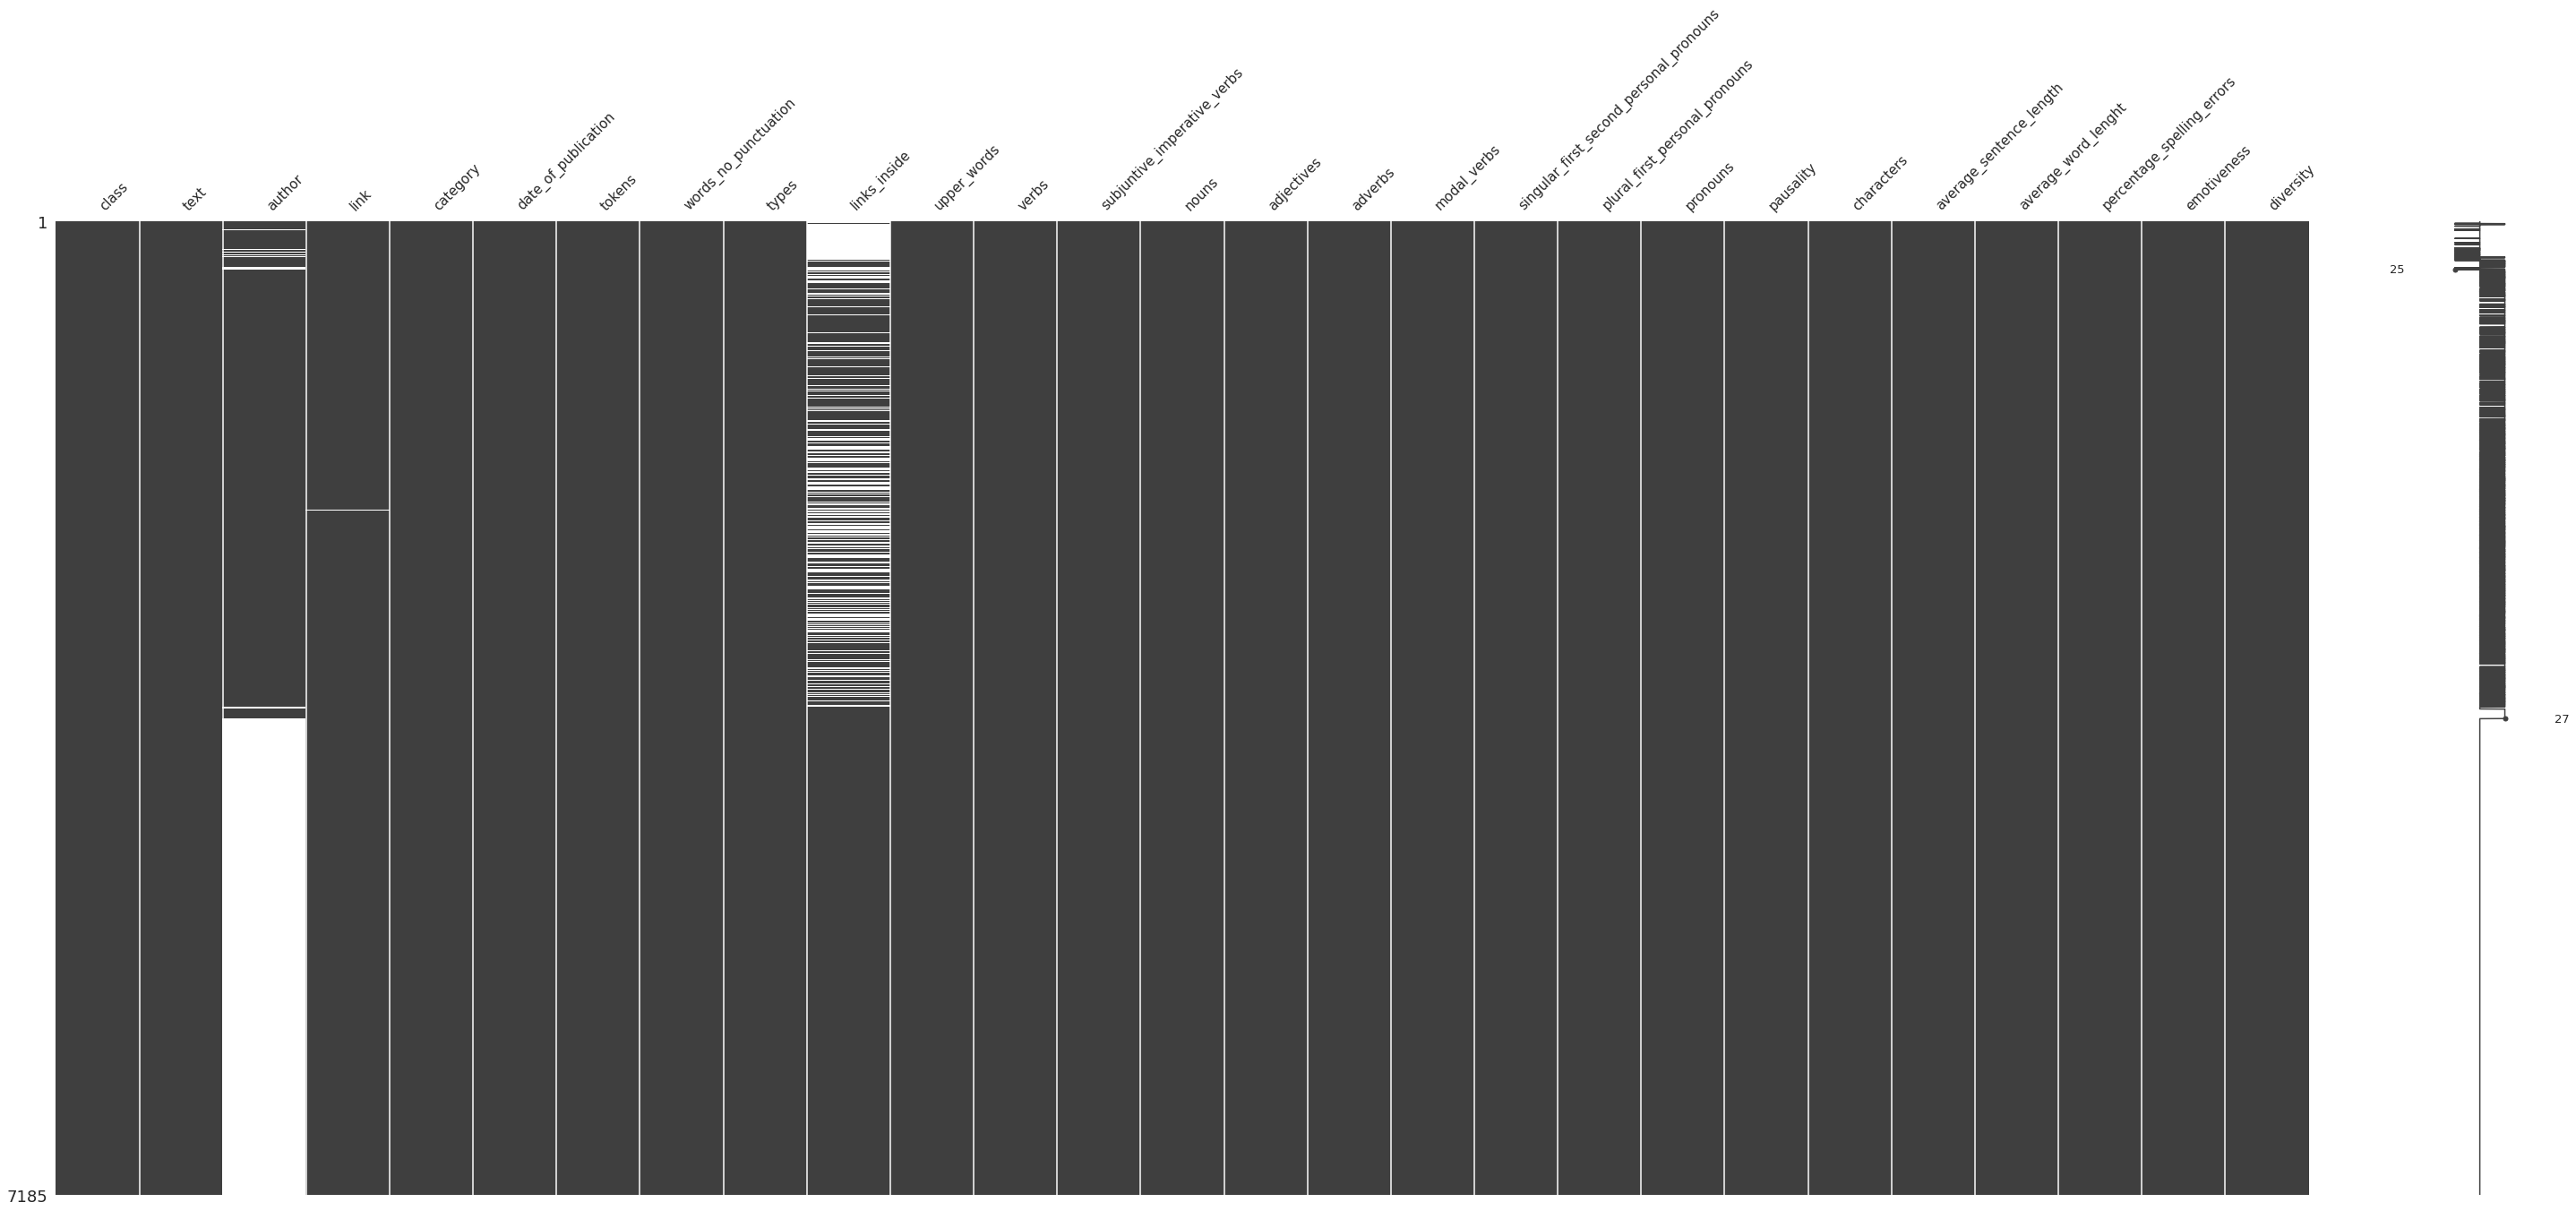

In [31]:
fig = msno.matrix(data_df, figsize=(50, 20), fontsize=15)
print(fig.get_figure().get_size_inches())
fig.get_figure().savefig(REPORTS_PATH / f'missing_values.jpg')
# plt.close(fig)
# msno.matrix(data_df, figsize=(20, 5), fontsize=15)

In [32]:
plt.close()

Analisando a imagem acima, podemos ver que aproximadamente metade da coluna de autores não existe e se levar-mos em consideração que os dados na parte de cima pertencem a classe de noticias verdadeiras. Vamos analisar esse caso:

In [33]:
print(data_df[data_df["class"] == 'True'].author.isna().sum() / len(data_df[data_df["class"] == 'True']))
print(data_df[data_df["class"] == 'Fake'].author.isna().sum() / len(data_df[data_df["class"] == 'Fake']))

0.012552301255230125
0.98


Como esperado, temos que 98% das noticias de Fake News não apresentam o autor do texto. Só falta verificarmos se é um problema de coleta ou um fato observado nas notícias falsas. Isso pode ser feito analisando alguns links das fake news. Por exemplo:

In [34]:
data_df[data_df["class"] == 'Fake'].sample(10)[["link", "author"]].values

array([['https://www.diariodobrasil.org/record-prepara-demissao-de-pha-que-podera-concorrer-a-cargo-publico-pelo-pt/',
        nan],
       ['https://www.diariodobrasil.org/farinha-do-mesmo-saco-governo-temer-vai-atras-de-lula-para-solucionar-crise-economica/',
        nan],
       ['https://www.diariodobrasil.org/quebra-pau-no-senado-parlamentar-chama-colega-para-briga-vamos-la-fora/',
        nan],
       ['https://www.diariodobrasil.org/internet-limitada-12-horas-de-netflix-ou-alguns-dias-no-facebook-ja-seriam-suficiente-para-bloquear-sua-internet/',
        nan],
       ['https://www.diariodobrasil.org/previsoes-de-carlinhos-20172018-lula-preso-temer-fora-alvaro-dias-presidente-e-novo-acidente-aereo/',
        nan],
       ['https://www.diariodobrasil.org/ninguem-melhor-que-o-proprio-lula-para-explicar-como-funciona-o-bolsa-familia/',
        nan],
       ['https://www.diariodobrasil.org/malafaia-defende-bolsonaro-e-acaba-com-a-folha-sp-jornalismo-sujo-esquerdopatas-vao-elege-lo-no

Analisando alguns dos casos acima é possível ver que pelo menos atualmente existem campos de autores nos links das notícias. Outras notícias não são encontradas mais nas páginas. Como benefício da dúvida, vamos remover a variável de autor já que ela não irá contribuir para um estudo comparativo entre notícias fake e reais. 

In [35]:
data_df = data_df.drop(columns="author")

Vamos agora olhar a variável "links inside". Levando em consideração a mesma disposição dos dados, temos uma possível correlação alta entre a classe de notícias reais e a ausência de links dentro do texto. 

In [36]:
print(data_df[data_df["class"] == 'True'].links_inside.isna().sum() / len(data_df[data_df["class"] == 'True']))
print(data_df[data_df["class"] == 'Fake'].links_inside.isna().sum() / len(data_df[data_df["class"] == 'Fake']))

0.38605299860529985
0.0


Como pode ser visto, temos uma quantidade considerável de dados perdidos de links dentro do texto. Resta saber como devemos fazer o procedimento desses casos.

In [37]:
data_df[(data_df["class"] == 'True') & (data_df["links_inside"].isna())].sample(10)[["link", "links_inside"]].values

array([['https://g1.globo.com/sao-paulo/noticia/nao-vou-rir-nem-vou-chorar-diz-lula-sobre-acusacoes-de-marcelo-odebrecht.ghtml',
        nan],
       ['https://g1.globo.com/sp/ribeirao-preto-franca/noticia/ex-policial-acusado-de-liderar-grupo-de-exterminio-vai-a-juri-popular-por-morte-de-dona-de-casa-ha-14-anos.ghtml',
        nan],
       ['http://economia.estadao.com.br/noticias/geral,sobre-incertezas-e-sangue-frio,70002129941',
        nan],
       ['https://g1.globo.com/sao-paulo/noticia/delator-diz-que-deu-r-6-milhoes-em-caixa-2-para-salsicha-tesoureiro-da-campanha-de-alckmin-de-2014.ghtml',
        nan],
       ['https://g1.globo.com/politica/noticia/onyx-xinga-lula-de-ladrao-e-deputado-do-pt-devolve-ladrao-e-voce-que-esta-na-lista.ghtml',
        nan],
       ['http://politica.estadao.com.br/blogs/coluna-do-estadao/pgr-reduz-equipe-que-investiga-grupo-politico-de-temer/',
        nan],
       ['http://politica.estadao.com.br/noticias/geral,temer-embarca-para-bahia-com-a-familia-

Nos links acima existem notícias com links internos, porém a maioria não. Existem várias abordagens pra prosseguirmos o estudo. A primeira, deletar a coluna já que temos uma grande quantidade de missing values. Levando em consideração características já estudadas sobre fake news e noticias reais, escolheremos a abordagem de adicionar zeros no lugar dos valores nulos. Portanto, poderemos estar adicionando um viés no estudo. É importante levar isso em consideração nas análises futuras:
>

%%capture

​

In [38]:
data_df.links_inside = data_df.links_inside.fillna(0)

## Outlier Analysis

In [39]:
# CONTINUOUS_VARIABLES = [x for x, y in data_df.dtypes.iteritems() if str(y) not in ('category', 'object')]
# SAVEFIG_FOLDER = REPORTS_PATH / "boxplots"
# SAVEFIG_FOLDER.mkdir(exist_ok=True, parents=True)

# for col in CONTINUOUS_VARIABLES:
#     fig = plt.figure(figsize=(6,8))
#     sns.boxplot(y=col, data=data_df[CONTINUOUS_VARIABLES])
#     plt.savefig(SAVEFIG_FOLDER/f'{col}.png')
#     plt.close()

# plt.show()

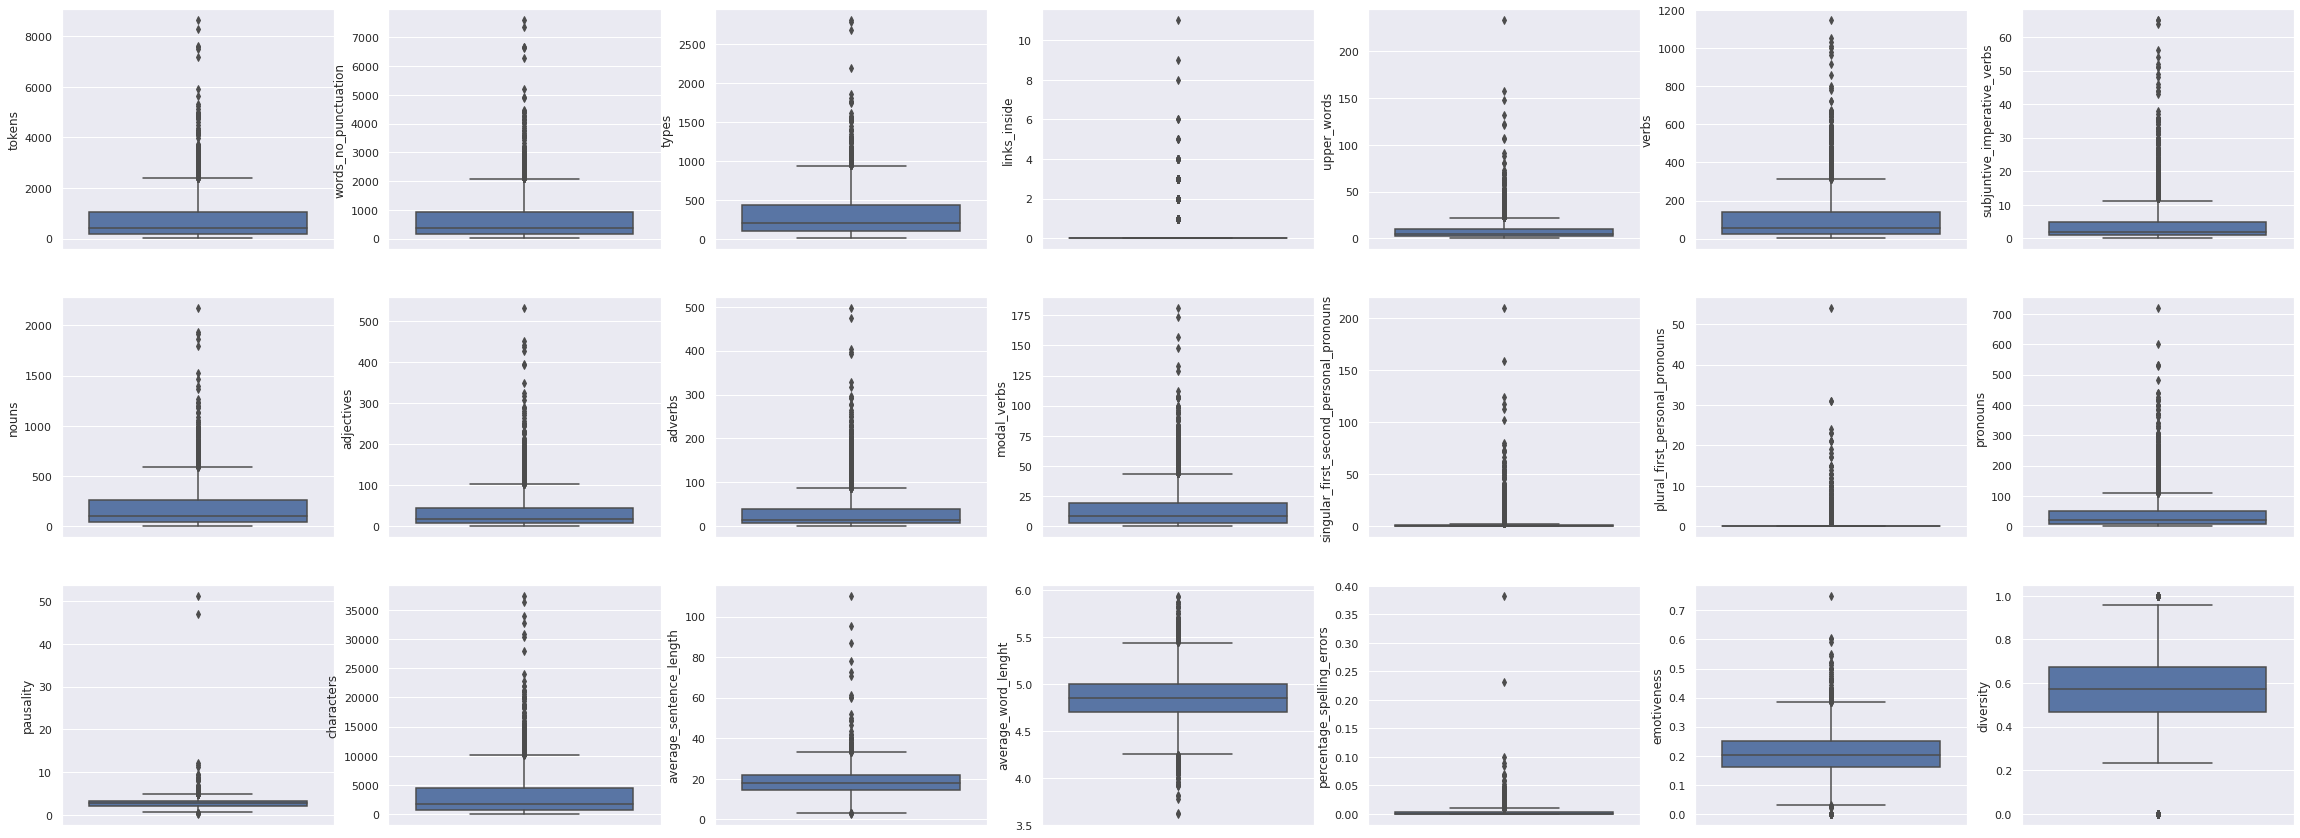

In [40]:
CONTINUOUS_VARIABLES = [x for x, y in data_df.dtypes.iteritems() if str(y) not in ('category', 'object')]

fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(40, 15), sharex=False, sharey=False)
for col, ax in zip(CONTINUOUS_VARIABLES, axes.flat):
    sns.boxplot(y=col, data=data_df[CONTINUOUS_VARIABLES], ax=ax)
    

SAVEFIG_FOLDER = REPORTS_PATH 
plt.savefig(SAVEFIG_FOLDER/'allboxplots.png')
plt.show()

Analisando os box plots acima todas as variáveis contém outliers. A abordagem aqui é avaliar os casos em que parece existir outliers errôneos. Por exemplo, existe um texto com mais de 200 palavras uppercase. Além disso um texto com quase 40% e outra com 25% de erros gramaticais. Em pausality temos dois casos com uma diferença muito grande. Vamos analisar esses casos em busca de possíveis erros:

In [41]:
# CONTINUOUS_VARIABLES = [x for x, y in data_df.dtypes.iteritems() if str(y) not in ('category', 'object')]
# SAVEFIG_FOLDER = REPORTS_PATH / "boxplots"
# SAVEFIG_FOLDER.mkdir(exist_ok=True, parents=True)

# for col in CONTINUOUS_VARIABLES:
#     fig = plt.figure(figsize=(6,8))
#     sns.boxplot(y=col, data=data_df[CONTINUOUS_VARIABLES])
#     plt.savefig(SAVEFIG_FOLDER/f'{col}.png')
#     plt.close()

# plt.show()

In [42]:
def iqr_outlier_finder(df, variable):
    q1 = df[variable].quantile(.25)
    q3 = df[variable].quantile(.75)
    iqr = q3 - q1
    q_hi = q3 + 1.5 * iqr
    q_low = q1 - 1.5 * iqr
    return df[(df[variable] >=  q_hi) | (df[variable] <= q_low)]

Primeiramente vamos analisar upper_words

In [43]:
outliers_df = iqr_outlier_finder(data_df, "upper_words").sort_values('upper_words', ascending=False)
print(f'Qtd Outliers: {len(outliers_df)}')
outliers_df.head(3)

Qtd Outliers: 534


,class,text,link,category,date_of_publication,tokens,words_no_punctuation,types,links_inside,upper_words,verbs,subjuntive_imperative_verbs,nouns,adjectives,adverbs,modal_verbs,singular_first_second_personal_pronouns,plural_first_personal_pronouns,pronouns,pausality,characters,average_sentence_length,average_word_lenght,percentage_spelling_errors,emotiveness,diversity
1455,True,cartas pac 2 ano...,http://opiniao.e...,tv_celebridades,01 de abril de ...,7608.0,6674.0,2782.0,0.0,233.0,1002.0,56.0,1863.0,428.0,403.0,108.0,13.0,4.0,482.0,2.54496,33862.0,18.1853,5.07372,0.023524,0.290052,0.41684
476,True,cartas democraci...,http://opiniao.e...,tv_celebridades,25 de março de ...,8279.0,7348.0,2805.0,0.0,157.0,1148.0,64.0,1936.0,452.0,474.0,157.0,19.0,15.0,602.0,2.07812,36369.0,16.4018,4.94951,0.022319,0.300259,0.38173
332,True,cartas apoio a c...,http://opiniao.e...,politica,24 de março de ...,7516.0,6645.0,2680.0,0.0,148.0,1015.0,65.0,1791.0,395.0,392.0,112.0,8.0,9.0,528.0,2.41274,32770.0,18.4072,4.93153,0.021069,0.280470,0.40331


In [44]:
outliers_df.head().link.values

array(['http://opiniao.estadao.com.br/noticias/geral,cartas,532303',
       'http://opiniao.estadao.com.br/noticias/geral,cartas,528953',
       'http://opiniao.estadao.com.br/noticias/geral,cartas,528433',
       'https://www.diariodobrasil.org/lista-dos-29-deputados-da-ccj-que-votaram-pelo-arquivamento-das-denuncias-contra-temer/',
       'http://politica.estadao.com.br/noticias/geral,veja-a-ordem-de-votacao-dos-deputados-a-respeito-da-denuncia,70001918690'],
      dtype=object)

Analisando o link acima, o texto é composto por cartas, em geral, cartas contém palavras em maiúsculo nas assinaturas e cabeçalhos. Em outros casos são as siglas dos partidos. Os outros dois maiores outliers também tem a mesma estrutura. Logo os valores fazem sentido. Vamos agora pra análise de erros gramaticais. 

In [45]:
outliers_df = iqr_outlier_finder(data_df, "percentage_spelling_errors").sort_values('percentage_spelling_errors', ascending=False)
print(f'Qtd Outliers: {len(outliers_df)}')
outliers_df.head()

Qtd Outliers: 611


,class,text,link,category,date_of_publication,tokens,words_no_punctuation,types,links_inside,upper_words,verbs,subjuntive_imperative_verbs,nouns,adjectives,adverbs,modal_verbs,singular_first_second_personal_pronouns,plural_first_personal_pronouns,pronouns,pausality,characters,average_sentence_length,average_word_lenght,percentage_spelling_errors,emotiveness,diversity
4269,Fake,internauta filma...,https://www.diar...,tv_celebridades,02/10/2017,161.0,136.0,111.0,0.0,0.0,21.0,2.0,58.0,4.0,5.0,2.0,0.0,0.0,11.0,1.666670,597.0,9.06667,4.38971,0.382353,0.113924,0.81617
669,True,nos cometemos er...,https://g1.globo...,tv_celebridades,21/03/2018 16h48,2428.0,2215.0,832.0,0.0,1.0,343.0,43.0,899.0,75.0,95.0,32.0,4.0,6.0,185.0,1.954130,11026.0,20.32110,4.97788,0.231151,0.136876,0.37562
4386,Fake,brasileiro que m...,https://www.diar...,tv_celebridades,12/09/2017,29.0,20.0,18.0,1.0,1.0,3.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,1.0,3.000000,107.0,6.66667,5.35000,0.100000,0.100000,0.00000
5489,Fake,midia internacio...,https://www.diar...,sociedade_cotidiano,29/11/2016,202.0,169.0,122.0,0.0,3.0,24.0,3.0,56.0,9.0,4.0,2.0,1.0,0.0,8.0,2.357140,758.0,12.07140,4.48521,0.088757,0.162500,0.72189
6825,Fake,fiocruz alerta q...,https://www.diar...,politica,06/02/2016,14.0,12.0,12.0,0.0,1.0,4.0,0.0,4.0,1.0,0.0,2.0,0.0,0.0,0.0,0.666667,58.0,4.00000,4.83333,0.083333,0.125000,1.00000


In [46]:
outliers_df.head().link.values

array(['https://www.diariodobrasil.org/internauta-filma-homem-flutuando-entre-raios/',
       'https://g1.globo.com/economia/tecnologia/noticia/nos-cometemos-erros-diz-mark-zuckerberg-sobre-escandalo-do-facebook-com-cambridge-analytica.ghtml',
       'https://www.diariodobrasil.org/brasileiro-que-mora-nos-eua-compara-miami-com-rio-de-janeiro-e-texto-viraliza-obrigado-furacao-irma/',
       'https://www.diariodobrasil.org/midia-internacional-destaca-o-vidente-carlinhos-que-supostamente-previu-o-acidente-aereo-de-hoje/',
       'https://www.diariodobrasil.org/fiocruz-alerta-que-virus-zika-pode-ser-transmitido-por-saliva-e-urina/'],
      dtype=object)

Note que as 4 primeiras notícias contém textos em inglês internamente o que pode ter contribuído na identificação como erros de grafia em portugues. O último caso em especial não aparenta ter problemas. Mesmo o valor sendo baixo, podemos visualizar o problema da seguinte forma: 

In [47]:
outliers_df.head().iloc[4].text

'fiocruz alerta que virus zika pode ser transmitido por saliva e urina '

In [48]:
text_before_cleaning.loc[6825]

'FIOCRUZ alerta que vírus zika pode ser transmitido por saliva e urina. . '

Note que no caso acima, no momento da extração o texto não estava completo. O erro provavelmente se encontra na palavra "Fiocruz" escrita sem acento no texto pequeno. Sendo assim temos $1/12=0.0833$ que é o valor encontrado na tabela. Note que também pode ser na pontuação feita de forma errada. Vamos agora verificar se existem erros em pausality:

In [49]:
outliers_df = iqr_outlier_finder(data_df, "pausality").sort_values('pausality', ascending=False)
print(f'Qtd Outliers: {len(outliers_df)}')
outliers_df.head()

Qtd Outliers: 120


,class,text,link,category,date_of_publication,tokens,words_no_punctuation,types,links_inside,upper_words,verbs,subjuntive_imperative_verbs,nouns,adjectives,adverbs,modal_verbs,singular_first_second_personal_pronouns,plural_first_personal_pronouns,pronouns,pausality,characters,average_sentence_length,average_word_lenght,percentage_spelling_errors,emotiveness,diversity
596,True,veja a ordem de ...,http://politica....,politica,01 de agosto de...,3079.0,2003.0,949.0,0.0,122.0,51.0,3.0,1141.0,17.0,26.0,3.0,0.0,0.0,17.0,51.2381,10115.0,95.3810,5.04993,0.000000,0.036074,0.47378
261,True,lula tem 34 bols...,https://g1.globo...,politica,2/12/2017,1317.0,801.0,186.0,0.0,15.0,41.0,2.0,352.0,25.0,7.0,1.0,0.0,0.0,18.0,46.9091,3436.0,72.8182,4.28964,0.001248,0.081425,0.23220
5612,Fake,forbes pele figu...,https://www.diar...,tv_celebridades,30/10/2016,226.0,165.0,101.0,0.0,14.0,20.0,0.0,50.0,3.0,4.0,1.0,0.0,0.0,0.0,12.2000,902.0,33.0000,5.46667,0.000000,0.100000,0.61212
6309,Fake,r 11 milhoes do ...,https://www.diar...,tv_celebridades,05/06/2016,252.0,182.0,114.0,0.0,17.0,14.0,0.0,65.0,8.0,3.0,1.0,0.0,0.0,4.0,11.6667,781.0,30.3333,4.29121,0.038462,0.139241,0.62637
4045,Fake,lula admite que ...,https://www.diar...,politica,15/12/2017,214.0,180.0,123.0,0.0,3.0,31.0,1.0,45.0,5.0,5.0,5.0,3.0,0.0,16.0,11.3333,759.0,60.0000,4.21667,0.000000,0.131579,0.68333


In [50]:
outliers_df.head().link.values

array(['http://politica.estadao.com.br/noticias/geral,veja-a-ordem-de-votacao-dos-deputados-a-respeito-da-denuncia,70001918690',
       'https://g1.globo.com/politica/noticia/lula-tem-34-bolsonaro-17-e-marina-9-aponta-pesquisa-datafolha-para-2018.ghtml',
       'https://www.diariodobrasil.org/forbes-pele-figura-entre-os-12-atletas-aposentados-mais-bem-pagos-do-mundo/',
       'https://www.diariodobrasil.org/r-11-milhoes-do-nosso-dinheiro-verba-da-petrobras-foi-usada-para-sustentar-sites-petistas/',
       'https://www.diariodobrasil.org/lula-admite-que-sera-condenado-por-novos-crimes-a-pf-e-o-mp-inventam-mentiras/'],
      dtype=object)

Infelizmente não consegui acesso a noticia original (paywall) então foi necessário analisar o texto diretamente

In [51]:
text_before_cleaning.loc[596]

'Veja a ordem de votação dos deputados a respeito da denúncia. Rio Grande do Sul é o estado que, percentualmente, tem mais votos declaradamente contrários a Temer.  A Câmara vota nesta quarta-feira, 2, a denúncia contra o presidente Michel Temer (PMDB) por corrupção passiva. A ordem de deputados a declararem seus votos no microfone do plenário será\xa0semelhante à da sessão do dia 17 de abril de 2016, dia em que a Casa autorizou a abertura do processo de impeachment contra a ex-presidente Dilma Rousseff (PT). Os parlamentares serão chamados em ordem alfabética, por Estado, alternadamente do Norte para o Sul e vice-versa. O Rio Grande do Sul é o estado que, percentualmente, tem mais votos contrários a Temer - até agora, 15 dos 31 parlamentares declararam que votarão pela aceitação da denúncia, 7 são contra e 16 estão indecisos ou não quiseram responder. A maior quantidade de votos a favor da acusação está nos estados do Sudeste e Nordeste, que juntos somam 132 dos votos já declarados ao

No primeiro texto, pode ser observado acima que o texto contém listas. Nesse caso a pausalidade pode ser considerada de acordo com os elementos \xa0 que representam o ponto inicial das listas (O valor de pausality é dependente da quantidade de pontos). De fato, são pausas, logo não se faz necessário remover o texto. Os outros textos analisados tem uma idéia parecida em relação aos seus textos.

## Exportando dados

In [52]:
PROCESSED_DATA_FOLDER = Path('data/processed/')
data_df.to_csv(PROCESSED_DATA_FOLDER/"fake_true_news_cleaned.csv")

In [53]:
len(data_df.columns)

26